In [13]:
import requests
import boto3
import json
import os
import sys
import argparse
import importlib
import transformers
import torch
import pathlib
import smart_open
import awswrangler as wr
from IPython.display import display
from sagemaker.huggingface.processing import HuggingFaceProcessor
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import FrameworkProcessor
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.workflow.pipeline_context import PipelineSession
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.session import get_execution_role


# Adding ../01_modules or ./01_modules to the system path so that we can load modules from 
# there as well
if '__file__' in globals():
    script_dir = pathlib.Path(__file__).parent.resolve()
else:
    script_dir = pathlib.Path().absolute()
modules_path_in_dev = os.path.abspath(os.path.join(script_dir, '..', '01_modules'))
modules_path_in_prod = os.path.abspath(os.path.join(script_dir, '01_modules'))
if os.path.exists(modules_path_in_dev):
    sys.path.append(modules_path_in_dev)
if os.path.exists(modules_path_in_prod):
    sys.path.append(modules_path_in_prod)


# # Jupyter only reads a local module the first time after 
# # kernel start. Re-running a cell with 
# # "from mymodulename import *" would not change
# # anything, even if the imported module has since changed.
# # As a workaround, we need to directly load the module, 
# # use importlib.reload to reload it and then import * 
import utils
_ = importlib.reload(utils)
import config
_ = importlib.reload(config)

utils.py loaded: v0.2.12
config.py loaded: v0.1


In [14]:

database_name = '02_stg'
table_name = 'stg_filtered_work_chapters_methodology_single'
id_columns = ['work_id']
text_column_name = 'chapter_text'
text_batch_size = 100000

utils.pd_set_options(cols=100)
id_column_names = ', '.join(id_columns)
# TODO: pagination
texts_df = wr.athena.read_sql_query(f"""
    SELECT
        {id_column_names}, {text_column_name} 
    FROM
        "{database_name}".{table_name}
    ORDER BY
        {id_column_names}
    LIMIT
        {text_batch_size}
    """,
    database_name
)
texts_only_list = texts_df[text_column_name].tolist()
texts_only_list[0][0:100]

'As was noted earlier, we formed our dataset utilizing the existing relations present in SNOMED CT. T'

In [15]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
embeddings = model.encode(texts_only_list)

# Source
Note: most of the code below is directly copied from https://medium.com/data-science/topic-modeling-with-bert-779f7db187e6 for the sake of experimentation, with only slight modifications by myself.

In [16]:
import umap
umap_embeddings = umap.UMAP(
    n_neighbors=15, 
    n_components=5, 
    metric='cosine'
).fit_transform(embeddings)

In [17]:
import hdbscan
cluster = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric='euclidean',                      
    cluster_selection_method='eom'
).fit(umap_embeddings)

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

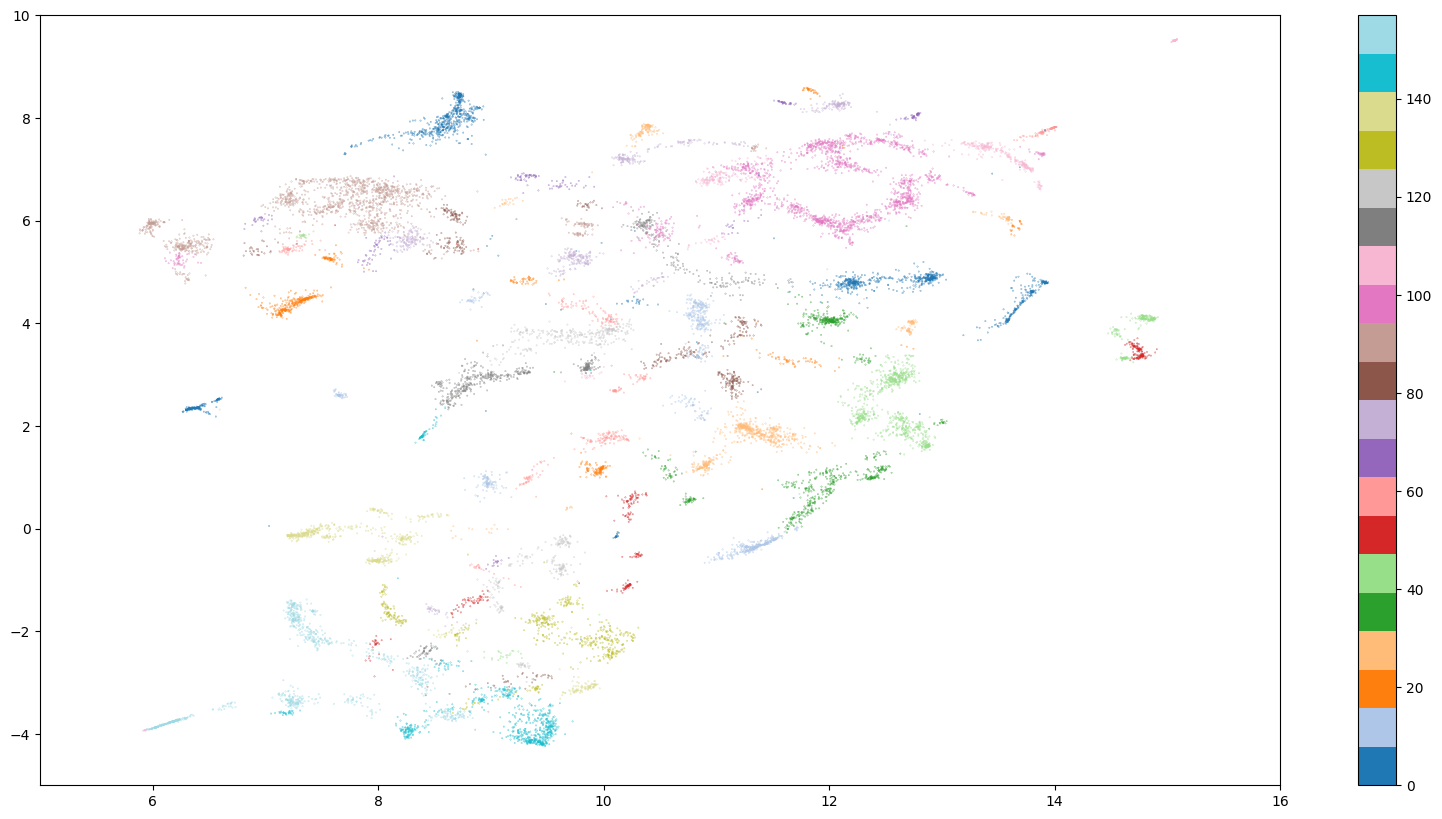

In [19]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
# plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='tab20') # 'viridis'
plt.xlim(5, 16)
plt.ylim(-5, 10)
plt.colorbar()
plt.show()

In [20]:
docs_df = pd.DataFrame(texts_only_list, columns=['Doc'])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df)) # TODO: real ids
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(texts_only_list))

In [21]:
count

CountVectorizer(stop_words='english')

In [22]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

,Topic,Size
0,-1,15579
91,90,1025
102,101,818
7,6,582
6,5,511
32,31,481
98,97,468
145,144,439
151,150,345
44,43,343


In [23]:
len(topic_sizes)

159

In [24]:
top_n_words

{-1: [('students', 0.003298382382475211),
  ('questions', 0.0030072261415443062),
  ('questionnaire', 0.002959333473889425),
  ('survey', 0.0029360596329143056),
  ('participants', 0.00289201972057722)],
 0: [('desk', 0.2506075603200302),
  ('basically', 0.10529916996737565),
  ('secondary', 0.10158733037619103),
  ('accessed', 0.09778576720081894),
  ('cost', 0.08753763361789031)],
 1: [('molecular', 0.03777956675140088),
  ('protein', 0.03524463514486014),
  ('docking', 0.03399008741505202),
  ('ligand', 0.027607367484744166),
  ('binding', 0.024349101142905796)],
 2: [('drug', 0.10641746640822211),
  ('drugs', 0.04749453496981439),
  ('metabolites', 0.04720949522455905),
  ('molecules', 0.04666532639964306),
  ('smiles', 0.03755380478975063)],
 3: [('watermark', 0.03630134955617849),
  ('encryption', 0.035643236425043995),
  ('secret', 0.02789819391678674),
  ('bit', 0.025698176327814896),
  ('key', 0.023979092618649864)],
 4: [('factors', 0.06510620510406741),
  ('cognitive', 0.053